# 0. Pytorch Paper Replicating

The goal of machinel earning research paper replicating: turn a ML research paper into usable code.

In this notebook, we'are going to be replicating the Vision Transformer (ViT) paper with PyTorch: https://arxiv.org/pdf/2010.11929

## 0. Get up
Let's import we've previously written

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 40.41 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Prepare transforms for images


In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into DataLoader's

In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c853fd80ca0>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize single image

In [8]:
# Get a batch of iamges
image_batch, label_batch = next(iter(train_dataloader))

# get a single image and label from the batch
image, label = image_batch[0], label_batch[0]
image.shape, label

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([3, 224, 224]), tensor(1))

Text(0.5, 1.0, 'pizza')

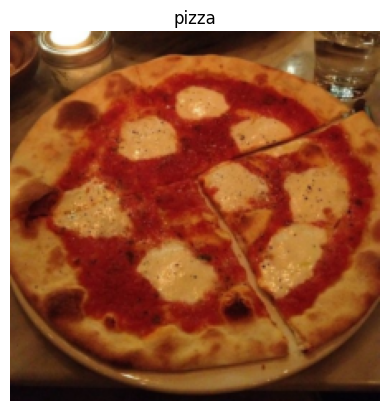

In [9]:
import matplotlib.pyplot as plt


plt.axis(False)
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])

## 3. Replicating ViT: Overview

Looking at a whole ML research paper can be imtimidating

We can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (e,g self-attention)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks

## 4. Equation 1: Split data into patches and creating the class, position, and patch embedding

Layers = input -> function -> ouput

What's input and output shape?







### 4.1 Calculating patch embedding input and output shapes by hand

* Input images: ${H}\times{W}\times{C}$
* Output images: ${N \times\left(P^{2} \cdot C\right)}$

* $H$ = height
* $W$ = width
* $C$ = color channels
* $P$ = patch size
* $N$ = number of patches = $H W / P^{2}$
* $D$ = constant latent vector size = embeddind dimension (table 1)

In [10]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16


# Calculate the number of patches
number_of_patches = int((height*width) // patch_size**2)
number_of_patches

196

In [11]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, (patch_size**2 * color_channels))

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

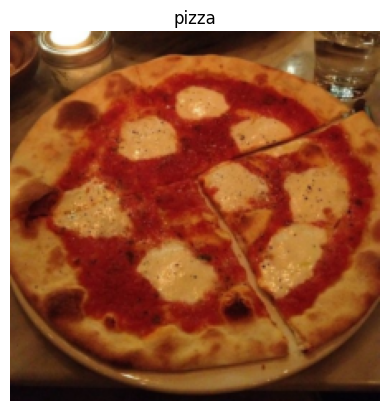

In [12]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

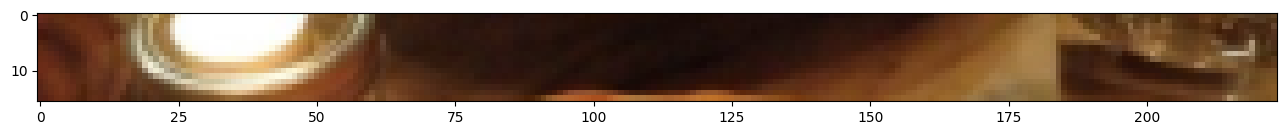

In [13]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


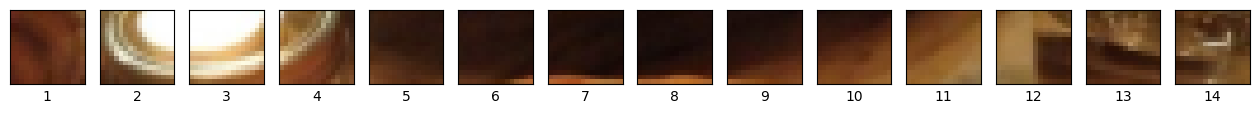

In [14]:
# Setup code to plot top row as patches
img_size =224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be devisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                         ncols=img_size // patch_size, # one column for each patch
                         sharex=True,
                         sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate hrough number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


Text(0.5, 0.98, 'pizza -> Patchified')

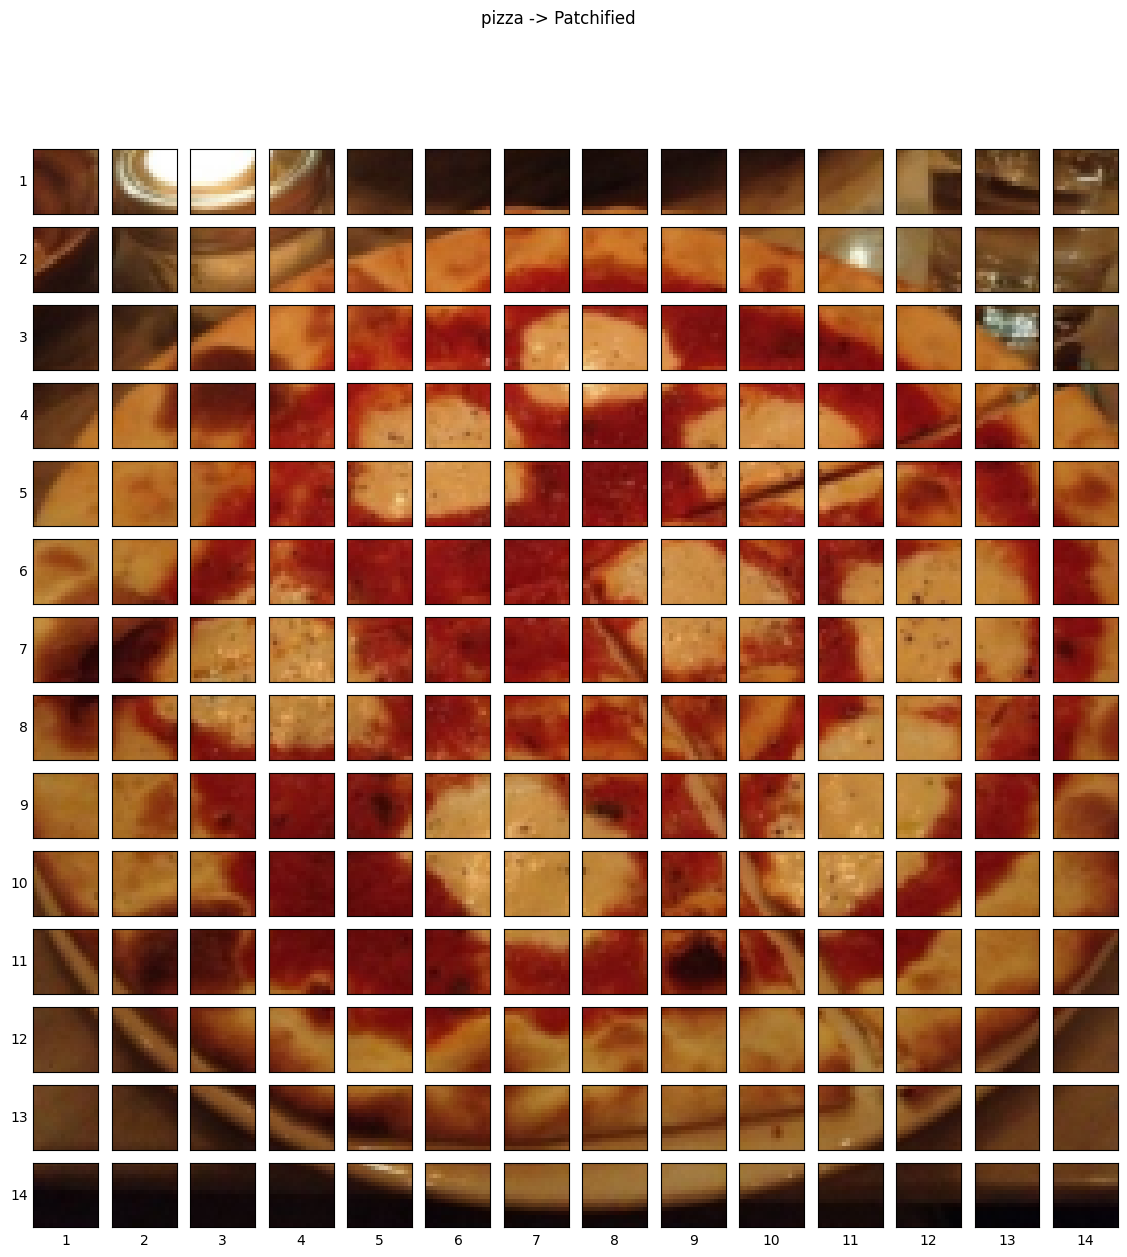

In [15]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop trough height and width
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                  patch_width:patch_width+patch_size,
                                  :])
    axs[i, j].set_ylabel(i+1,
                          rotation="horizontal",
                          horizontalalignment="right",
                          verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified")

### 4.3 Creating image patches and turning them into patch embeddings
We could create the image patches anad image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride to `patch_size`

In [16]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set patch size
patch_size = 16

# Create a conv2d layers with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, # from D size table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0
                   )
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

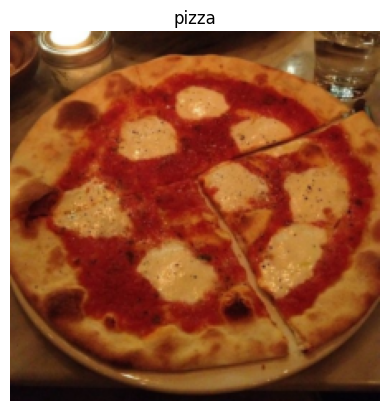

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [18]:
# Pass the image to conv layer
image_out_of_conv = conv2d(image.unsqueeze(0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Now we`ve passed a single iamge to our `conv2d` layer, it's shape is:
```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]

```

Showng random conv feature maps form indexes: [42, 486, 87, 480, 304]


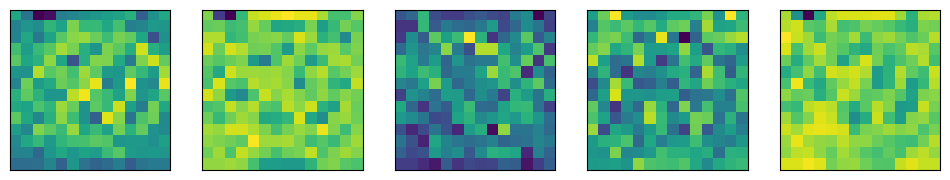

In [19]:
# plot andom conv feature map (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)

print(f"Showng random conv feature maps form indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.1331, -0.5958, -0.4034, -0.1628, -0.0627, -0.0459,  0.0019,
            0.0159, -0.0733, -0.1538, -0.2261, -0.1522, -0.0583, -0.0755],
          [-0.1086, -0.1384, -0.2435, -0.2216, -0.3206, -0.2391, -0.1925,
           -0.1696, -0.2089, -0.1622, -0.3079, -0.1480, -0.1998, -0.1746],
          [-0.0663, -0.1245, -0.2235, -0.2443, -0.1430, -0.0836, -0.3551,
           -0.3412, -0.1256, -0.0500, -0.0760, -0.2866, -0.3494, -0.1471],
          [-0.1841, -0.2507, -0.1329, -0.1416, -0.2614, -0.3158, -0.1379,
            0.0565, -0.1467, -0.3619, -0.2481, -0.1347, -0.1569, -0.1956],
          [-0.2492, -0.1648, -0.1561, -0.0900, -0.3099, -0.2510, -0.1034,
           -0.1142, -0.1767, -0.1236, -0.2893, -0.1256, -0.1020, -0.1369],
          [-0.1744, -0.1728, -0.0664, -0.1634, -0.1017, -0.1114, -0.1460,
           -0.2773, -0.3131, -0.2314, -0.1976, -0.2990, -0.1895, -0.1259],
          [ 0.0072, -0.1039, -0.2813, -0.2563, -0.1313, -0.1192, -0.0986,
           -0.1620, -0.2526, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Want: [batch_size, number_of_patches, embedding_dim]

In [21]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])



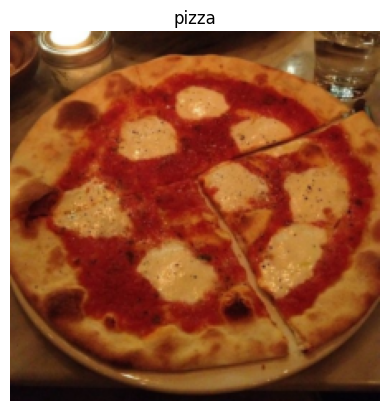

In [22]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}\n")


In [23]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

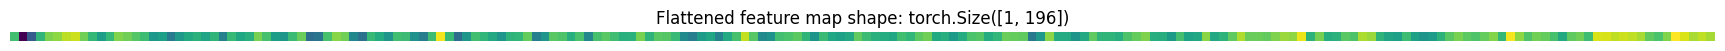

In [24]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

# Plot the flattened feature map
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

### 4.5 Turning the ViT patch embedding layer into Pytorch Module

1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Craeta a layer to flatten the feature maps of the outpus of the layer in 3
5. Define a `forward()` that defines the forward computations
6. Make sure the output shape layer reflects the required output shape of the patch embedding


In [25]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()
    self.patch_size = patch_size
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be dvisible by patch size.\nImage shape: {image_resolution}, patch size: {self.patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1) # [batch_size, num_patches, embedding_size]

In [26]:
# Create an instance of patch embedding layer
patchify = PatchEmbedding()

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")

patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Ouput patch embedding squence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Ouput patch embedding squence shape: torch.Size([1, 196, 768])


In [27]:
rand_image_tensor = torch.rand(1, 3, 224, 224)
rand_image_tensor_bad = torch.rand(1, 3, 250, 250)
patchify(rand_image_tensor)




tensor([[[-0.2900, -0.4770,  0.2757,  ...,  0.2341, -0.4140,  0.3130],
         [-0.2910,  0.1599,  0.1939,  ...,  0.4106, -0.4087,  0.2538],
         [-0.0610, -0.1407,  0.2090,  ...,  0.4194, -0.0958, -0.0300],
         ...,
         [ 0.0789, -0.0605,  0.4804,  ...,  0.2279, -0.2803,  0.3659],
         [ 0.0079, -0.2108,  0.3331,  ...,  0.3462, -0.7743,  0.3323],
         [-0.1786,  0.2464,  0.1989,  ...,  0.4928, -0.1726,  0.3874]]],
       grad_fn=<PermuteBackward0>)

```python
patchify(rand_image_tensor_bad)

AssertionError: Input image size must be dvisible by patch size.
Image shape: 250, patch size: 16
```

### 4.6 Creating the class token embedding
Prepend a learnable class token to the start of the patch embedding

In [28]:
patch_embedded_image

tensor([[[-0.1195,  0.0509,  0.0101,  ...,  0.1108, -0.1491,  0.0936],
         [-0.3926,  0.0904,  0.4385,  ...,  0.4950, -0.3890,  0.1768],
         [-0.4214, -0.1371,  0.5142,  ...,  0.5826, -0.4545,  0.4378],
         ...,
         [ 0.0042, -0.0264,  0.0158,  ...,  0.0223, -0.0574,  0.0348],
         [ 0.0177, -0.0637,  0.0799,  ...,  0.0460, -0.0788,  0.0461],
         [-0.0075, -0.0611,  0.0997,  ...,  0.0562, -0.0792,  0.0545]]],
       grad_fn=<PermuteBackward0>)

In [29]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [30]:
# Create class token embedding as a learnable parameter
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [31]:
# Add the class_token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, class_token + number_of_patches, embedding_dim]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1195,  0.0509,  0.0101,  ...,  0.1108, -0.1491,  0.0936],
         [-0.3926,  0.0904,  0.4385,  ...,  0.4950, -0.3890,  0.1768],
         ...,
         [ 0.0042, -0.0264,  0.0158,  ...,  0.0223, -0.0574,  0.0348],
         [ 0.0177, -0.0637,  0.0799,  ...,  0.0460, -0.0788,  0.0461],
         [-0.0075, -0.0611,  0.0997,  ...,  0.0562, -0.0792,  0.0545]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, class_token + number_of_patches, embedding_dim]


### 4.7 Creating the position embedding

Create a series of 1D learnable position embedding and add them to sequeunce of patch embeddings

In [32]:
# View the sequence of patch embeddings with the prepend class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1195,  0.0509,  0.0101,  ...,  0.1108, -0.1491,  0.0936],
          [-0.3926,  0.0904,  0.4385,  ...,  0.4950, -0.3890,  0.1768],
          ...,
          [ 0.0042, -0.0264,  0.0158,  ...,  0.0223, -0.0574,  0.0348],
          [ 0.0177, -0.0637,  0.0799,  ...,  0.0460, -0.0788,  0.0461],
          [-0.0075, -0.0611,  0.0997,  ...,  0.0562, -0.0792,  0.0545]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [33]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]


# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [34]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.8805, 1.0509, 1.0101,  ..., 1.1108, 0.8509, 1.0936],
          [0.6074, 1.0904, 1.4385,  ..., 1.4950, 0.6110, 1.1768],
          ...,
          [1.0042, 0.9736, 1.0158,  ..., 1.0223, 0.9426, 1.0348],
          [1.0177, 0.9363, 1.0799,  ..., 1.0460, 0.9212, 1.0461],
          [0.9925, 0.9389, 1.0997,  ..., 1.0562, 0.9208, 1.0545]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [35]:
### 4.8 Putting it all together: from image to embedding

set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shape of the original image and get image dimensions
print(f"Image tensor shape: {image.shape[2]}")

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")
# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                 requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")



Image tensor shape: 224
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA block)

* MSA: which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch we can use: `torch.nn.MultiheadAttention`
* LayerNorm: Layer normalization is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generatlization accuracy.
  * Normalization: make everything have the same mean and same standar deviation
  * In PyTorch: `torch.nn.LayerNorm`, normalize values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension
  * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.


In [36]:
class MultiheadSelfAttentionBlock(nn.Module):
  """
    create a multi-head self-attention block ("MSA Block")
  """
  def __init__(self,
               embedding_dim:int=768, # Hidden size D
               num_heads:int=12, # Heads from table 1 for Vit-Base
               attn_dropout:int=0):
    super().__init__()
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     dropout=attn_dropout,
                                                     batch_first=True) # (batch, seq, feature) -> [batch, number_patches, embedding_dimension]

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output


In [37]:
# Create an instance MSA block
multi_head_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                              num_heads=12,
                                                              attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multi_head_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP Block)

* **MLP**: Contains two layers with a GELU non-linearity
  * MLP: a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing: `torch.nn.Linear()` or `tf.keras.layers.Dense()`
  * GELU in pytorch `torch.nn.GELU`


```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```


In [38]:
class MLPBlock(nn.Module):
  """
    create a multilayer perceptions block
  """
  def __init__(self,
               embedding_dim:int=768, # Hidden size D
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x


In [39]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output MSA Block through MLP Block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MSA block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MSA block: {patched_image_through_mlp_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 7. Createing Transformer Encoder

Consist of alternating layers of MSA ana MLP.

And there arae residual connections between each block.

* Encoder = turn a sequence into learnable representation.
* Decoder = go from learn represntation back to some sequences.
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create Custom Transformer Encoder

In [40]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1
               num_heads:int=12, # from table 1
               mlp_size:int=3072, # from table 1
               mlp_dropout=0.1, # from table 3,
               attn_dropout:int=0):
    super().__init__()
    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
  def forward(self, x):
    x = self.msa_block(x) + x # residual / Additive skip-connection
    x = self.mlp_block(x) + x
    return x

In [41]:
# Create an instance of TrasformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layers

We can create a Transformer Encoder with Pytorch layers


In [42]:
# Create the same as above with pytorch layer
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden D Size table 1,
                                                             nhead=12, # from table 1
                                                             dim_feedforward=3072, # MLP size
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [43]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. Putting it all together to create VIT

In [44]:
# Create a VIT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "Layers" Vit-Base
               embedding_dim:int=768, # Hidden size D from Table 1
               mlp_size:int=3072, # Table1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embedding
               num_classes:int=1000):
    super().__init__()

    # Make an assertion for image size
    assert img_size % patch_size == 0, f"Image size must be divisible patch size, image: {img_size}, patch size: {patch_size}"


    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.rand(1, self.num_patches+1, embedding_dim),
                                           requires_grad=True)

    # Create sembedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # -1 means to infer the dimension

    # Create patch embedding
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply embedding dropout
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
    x = self.transformer_encoder(x)


    # Put 0th index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])

    return x


In [45]:
set_seeds()

# Craete a random image tensor
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT
vit = ViT(num_classes=3)

# Pass the random tensor to our ViT
vit(random_image_tensor)

tensor([[0.7046, 1.0321, 0.4736]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary

In [46]:
from torchinfo import summary

# Get a summary
summary(model=ViT(num_classes=1000),
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for out custom ViT


### 9.1 Creating optimizer

 The paper states is uses Adam Optimizer (section 4, Training & fine-tuning) with $B1$ value of 0.9, $B2$ 0.999, and weight decay of 0.1


Regularization = prevents overfitting

In [47]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             weight_decay=0.1)

### 9.2 Creating loss function

In [48]:
loss_fn = nn.CrossEntropyLoss()

### 9.3 Training our ViT Model

In [49]:
from going_modular.going_modular import engine

set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7900 | train_acc: 0.4219 | test_loss: 2.1082 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.6242 | train_acc: 0.2344 | test_loss: 1.7736 | test_acc: 0.2604
Epoch: 3 | train_loss: 2.1068 | train_acc: 0.3320 | test_loss: 1.2486 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.2825 | train_acc: 0.4297 | test_loss: 1.6579 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.2986 | train_acc: 0.2891 | test_loss: 1.3236 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1304 | train_acc: 0.4297 | test_loss: 2.6020 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.5373 | train_acc: 0.3203 | test_loss: 2.3630 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.7682 | train_acc: 0.2812 | test_loss: 1.7639 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.4974 | train_acc: 0.4375 | test_loss: 1.3431 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4165 | train_acc: 0.3008 | test_loss: 1.4451 | test_acc: 0.2604


### 9.4 What our training setup is missing

The original ViT paper uses a far larger amount of data that ours (in deep learning, more data is generally always a good thing) and a longer training schedule.

The main things our training implementation is missing:

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* Learning rate warmup - start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevent gradients from getting too big

### 9.5 Plotting loss curves

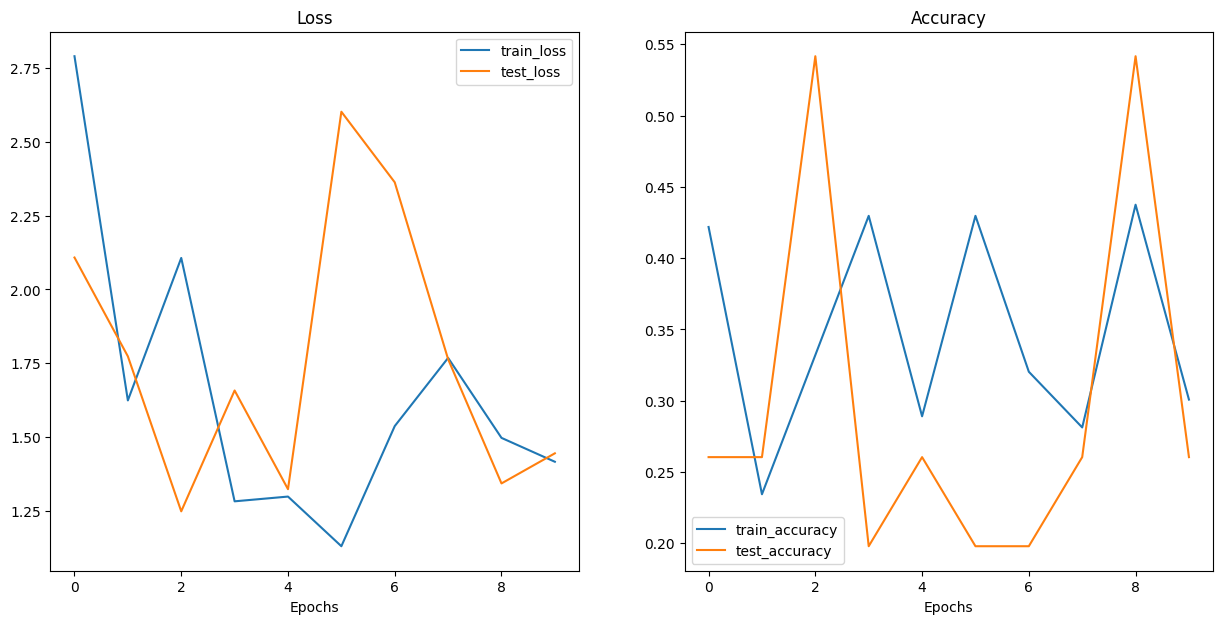

In [50]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models`



In [9]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 10.2 Prepared ViT model

In [11]:
from torchvision import models

# Get pretrained weights for ViT-Base
pretrained_vit_weights = models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model
pretrained_vit = models.vit_b_16(weights=pretrained_vit_weights)



Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 99.1MB/s]


In [12]:
# Freeze parameters
for p in pretrained_vit.parameters():
  p.requires_grad = False

  pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [13]:
from torchinfo import summary

# Get a summary
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for pretrained ViT Model

In [14]:
# Get automatic transforms from pretrained ViT weights

vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [15]:
from going_modular.going_modular import data_setup

# Setup dataloader
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)

### 10.4 Train feature extractor ViT model

In [16]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7638 | train_acc: 0.7266 | test_loss: 0.5106 | test_acc: 0.8580
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9375 | test_loss: 0.3227 | test_acc: 0.9290
Epoch: 3 | train_loss: 0.2015 | train_acc: 0.9570 | test_loss: 0.2631 | test_acc: 0.9290
Epoch: 4 | train_loss: 0.1536 | train_acc: 0.9688 | test_loss: 0.2345 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1235 | train_acc: 0.9727 | test_loss: 0.2235 | test_acc: 0.9081
Epoch: 6 | train_loss: 0.1204 | train_acc: 0.9805 | test_loss: 0.2095 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9844 | test_loss: 0.2306 | test_acc: 0.9186
Epoch: 8 | train_loss: 0.0805 | train_acc: 0.9844 | test_loss: 0.2234 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1072 | train_acc: 0.9844 | test_loss: 0.2019 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.0659 | train_acc: 0.9922 | test_loss: 0.1743 | test_acc: 0.9176


### 10.5 Plot the loss curves

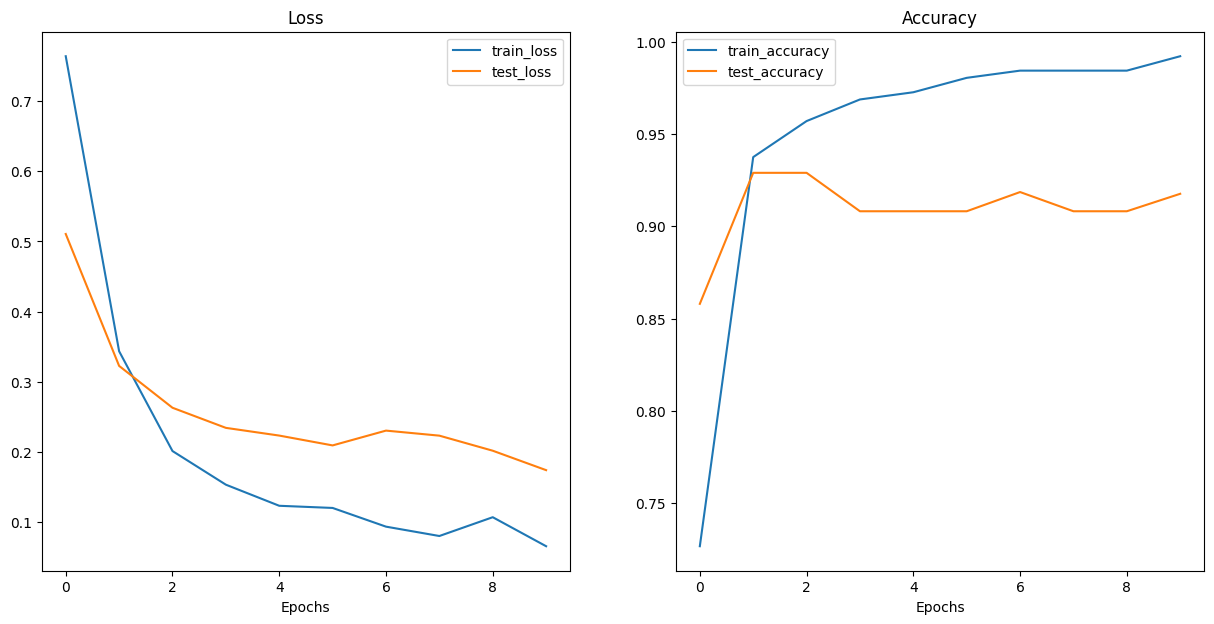

In [17]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save model state dict

In [18]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [19]:
from pathlib import Path

# Get the model size in megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT features extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT features extractor model size: 327 MB
